Customer churn refers to the customers who no longer interact with the business. It is important to predict churn because acquiring new customers is more costly than retaining existing ones.

Let's start with importing the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

Loading and learning more about our dataset that was collected from here: https://www.kaggle.com/datasets/uom190346a/e-commerce-customer-behavior-dataset

In [3]:
df = pd.read_csv('churn.csv')
df.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,1120.20,14,4.6,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.0,True,55,Unsatisfied


In [4]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               350 non-null    int64  
 1   Gender                    350 non-null    object 
 2   Age                       350 non-null    int64  
 3   City                      350 non-null    object 
 4   Membership Type           350 non-null    object 
 5   Total Spend               350 non-null    float64
 6   Items Purchased           350 non-null    int64  
 7   Average Rating            350 non-null    float64
 8   Discount Applied          350 non-null    bool   
 9   Days Since Last Purchase  350 non-null    int64  
 10  Satisfaction Level        348 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 27.8+ KB


1. Cleaning

In [5]:
# handling duplicated rows

duplicates = df.duplicated()

print("Duplicate Rows:")
print(df.loc[duplicates])

Duplicate Rows:
Empty DataFrame
Columns: [Customer ID, Gender, Age, City, Membership Type, Total Spend, Items Purchased, Average Rating, Discount Applied, Days Since Last Purchase, Satisfaction Level]
Index: []


There are two missing values in the 'Satisfaction Level' column.

In [6]:
missing = df.isnull()

print("Rows with Missing Values:")
print(df.loc[missing.any(axis=1)])

Rows with Missing Values:
     Customer ID  Gender  Age     City Membership Type  Total Spend  \
71           172  Female   37  Houston          Bronze        420.8   
143          244  Female   37  Houston          Bronze        430.8   

     Items Purchased  Average Rating  Discount Applied  \
71                 7             3.1             False   
143                7             3.4             False   

     Days Since Last Purchase Satisfaction Level  
71                         21                NaN  
143                        23                NaN  


Is 'Unsatisfied' the majority in this subset?


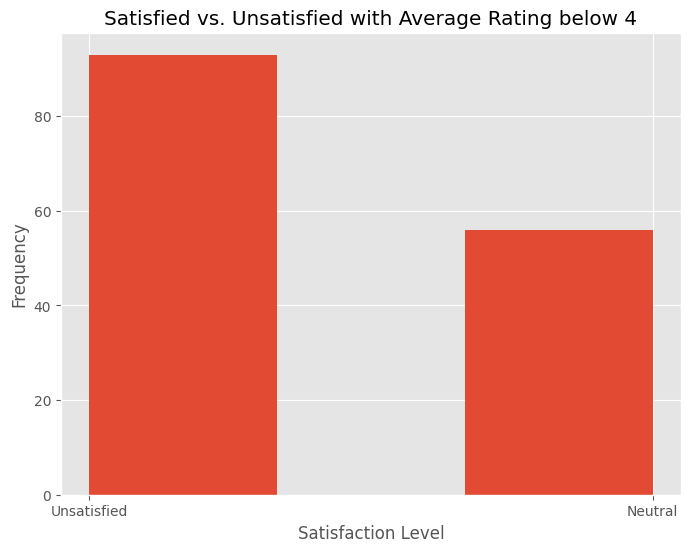

In [12]:
# handling missing values

low_rating_customers = df[(df['Average Rating'] < 4) & (~df['Satisfaction Level'].isnull())]

satisfaction_dist = low_rating_customers['Satisfaction Level'].value_counts()

unsatisfied = satisfaction_dist.get('Unsatisfied', 0) > satisfaction_dist.get('Satisfied', 0)
print("Is 'Unsatisfied' the majority in this subset?")

plt.figure(figsize = (8,6))
plt.hist(low_rating_customers['Satisfaction Level'], bins = 3)
plt.title('Satisfied vs. Unsatisfied with Average Rating below 4')
plt.xlabel('Satisfaction Level')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Let's assume the missing values are both 'Unsatisfied', as the average rating is below 4 for both rows.

In [10]:
# filling the null cells

df.fillna({'Satisfaction Level': 'Unsatisfied'}, inplace = True)

missing = df.isnull()

print("Rows with Missing Values:")
print(df.loc[missing.any(axis=1)])

Rows with Missing Values:
Empty DataFrame
Columns: [Customer ID, Gender, Age, City, Membership Type, Total Spend, Items Purchased, Average Rating, Discount Applied, Days Since Last Purchase, Satisfaction Level]
Index: []


In [11]:
# the descriptive stats

df.describe()

,Customer ID,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,275.500000,33.597143,845.381714,12.600000,4.019143,26.588571
std,101.180532,4.870882,362.058695,4.155984,0.580539,13.440813
min,101.000000,26.000000,410.800000,7.000000,3.000000,9.000000
25%,188.250000,30.000000,502.000000,9.000000,3.500000,15.000000
50%,275.500000,32.500000,775.200000,12.000000,4.100000,23.000000
75%,362.750000,37.000000,1160.600000,15.000000,4.500000,38.000000
max,450.000000,43.000000,1520.100000,21.000000,4.900000,63.000000


I am looking at the age, total spend and items purchased columns. There seem to be no extreme outliers, however, a boxplot will help us understand the statistics more clearly.

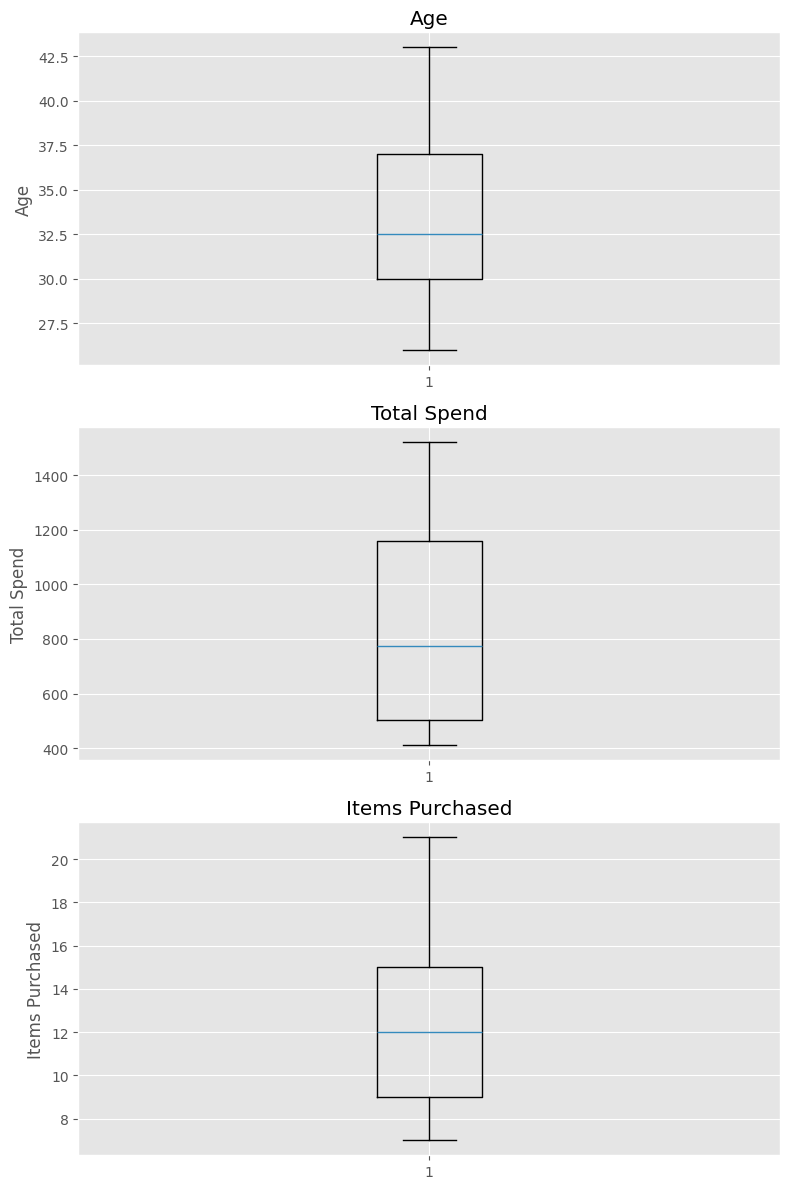

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Age
axs[0].boxplot(df['Age'])
axs[0].set_title('Age')
axs[0].set_ylabel('Age')

# Total Spend
axs[1].boxplot(df['Total Spend'])
axs[1].set_title('Total Spend')
axs[1].set_ylabel('Total Spend')

# Items Purchased
axs[2].boxplot(df['Items Purchased'])
axs[2].set_title('Items Purchased')
axs[2].set_ylabel('Items Purchased')

plt.tight_layout()

plt.show()

Here's what the boxplots are implying:

1. The average customer's age is 32+, with an average spend of a little less than $800, and the average number of items purchased by a customer is 12.
2. There are no extreme outliers.

EDA

   Here's where we will find out who the loyal customers are, and which customers will be potentially churned. Additionally, if there is any significant
   statistical difference between the two groups of customers.

Starting with an easy question:
1. What does the demographic of the top spending customer look like?

In [14]:
# Calculating total spend for each customer
customer_total_spend = df.groupby('Customer ID')['Total Spend'].sum()

top_spending_customers = customer_total_spend.nlargest(35)  # Assuming top 10% customers
top_spending_customers_info = df[df['Customer ID'].isin(top_spending_customers.index)]
demographic_profile = top_spending_customers_info[['Customer ID', 'Gender', 'Age', 'Membership Type']].drop_duplicates()

print("Demographic Profile of Top Spending Customers:")
print(demographic_profile)

Demographic Profile of Top Spending Customers:
     Customer ID Gender  Age Membership Type
3            104   Male   30            Gold
9            110   Male   28            Gold
21           122   Male   30            Gold
27           128   Male   28            Gold
39           140   Male   30            Gold
45           146   Male   28            Gold
51           152   Male   30            Gold
57           158   Male   28            Gold
69           170   Male   30            Gold
75           176   Male   28            Gold
81           182   Male   30            Gold
87           188   Male   28            Gold
105          206   Male   28            Gold
111          212   Male   30            Gold
117          218   Male   28            Gold
135          236   Male   28            Gold
141          242   Male   30            Gold
147          248   Male   28            Gold
153          254   Male   30            Gold
159          260   Male   28            Gold
177     

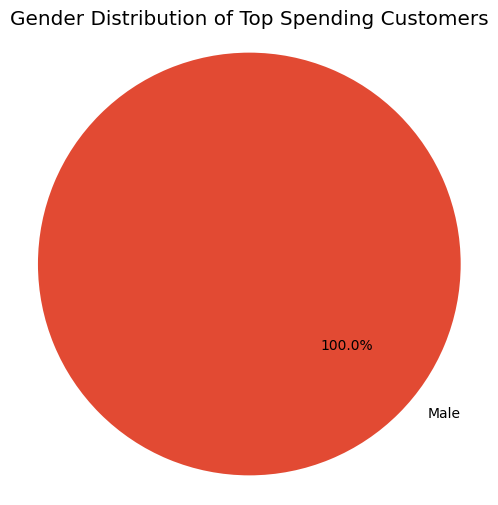

In [17]:
gender_counts = demographic_profile['Gender'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution of Top Spending Customers')
plt.axis('equal')
plt.show()

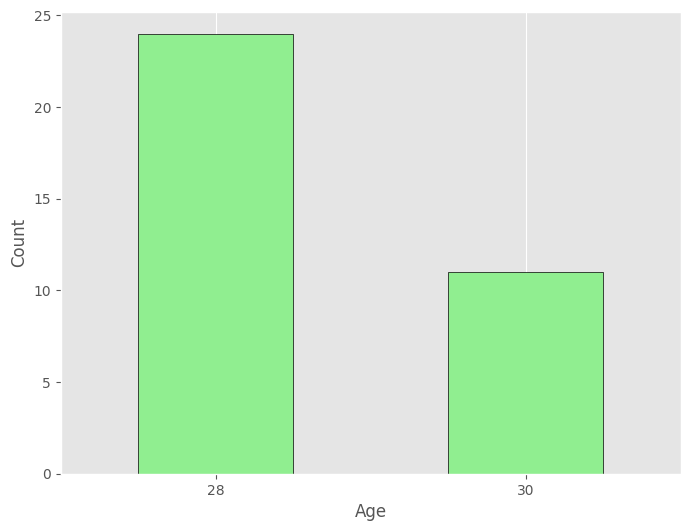

In [18]:
age_counts = demographic_profile['Age'].value_counts().sort_index()

# plotting the bar graph

plt.figure(figsize = (8,6))
age_counts.plot(kind = 'bar', color = 'lightgreen', edgecolor = 'black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

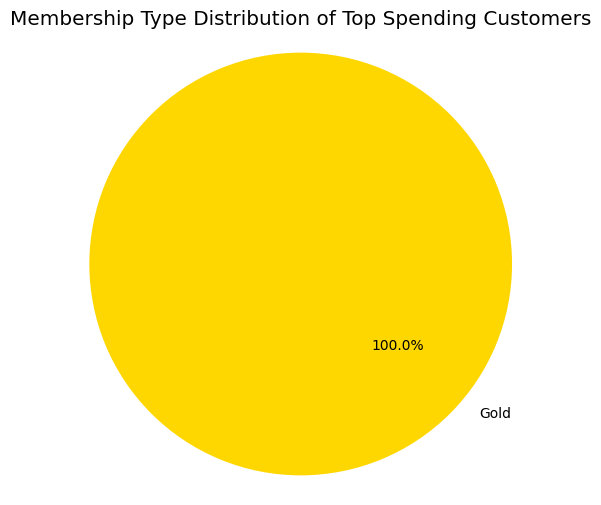

In [20]:
membership_counts = demographic_profile['Membership Type'].value_counts()

# Plotting the pie chart for Membership Type
plt.figure(figsize=(6, 6))
plt.pie(membership_counts, labels=membership_counts.index, autopct='%1.1f%%', colors=['gold', 'silver', 'bronze'], startangle=140)
plt.title('Membership Type Distribution of Top Spending Customers')
plt.axis('equal')
plt.show()

The top 10% customer who spent the most are all male, between the ages 28-30, and all are Gold members. It may seem unrealistic but it is what the data represents.

2. What percentage of the total revenue is generated by these customers?

In [21]:
# calculating revenue generated by the top 10% customers
revenue_by_top10 = top_spending_customers_info['Total Spend'].sum()

# calculating total revenue
revenue = df['Total Spend'].sum()

# calculating the percentage of total revenue generated by the top 10% customers
percentage_revenue_top_10_percent = (revenue_by_top10 / revenue) * 100

print("Percentage of Total Revenue Generated by Top 10% of Customers:", round(percentage_revenue_top_10_percent, 2), "%")

Percentage of Total Revenue Generated by Top 10% of Customers: 17.57 %


In [22]:
df['Customer ID'].value_counts

<bound method IndexOpsMixin.value_counts of 0      101
1      102
2      103
3      104
4      105
      ... 
345    446
346    447
347    448
348    449
349    450
Name: Customer ID, Length: 350, dtype: int64>

3. Who are the most loyal customers?

   Since we do not have the data of the customers' purchase history, we cannot take the frequency of purchases as the criteria. The days since last purchase column does not actually indicate whether or not a customer is loyal.
   So I have decided upon two criterias for loyal customers:
    1. Satisfaction Level - Satisfied
    2.  Average rating - Above 4
   
   The Null hypthesis would be: Loyal Customers will have a lower amount of total spending and will have purchased more items than than the rest of the customers, and Loyal Customers will not have purchased more recently than other customers.
   The alternative hypothesis would be the opposite.

In [24]:
loyal_customers = df[(df['Satisfaction Level'] == 'Satisfied') & (df['Average Rating'] >= 4)]
churned_customers = df[(df['Satisfaction Level'] == 'Unsatisfied') & (df['Average Rating'] < 4)]
need_attention = df[df['Satisfaction Level'] == 'Neutral']

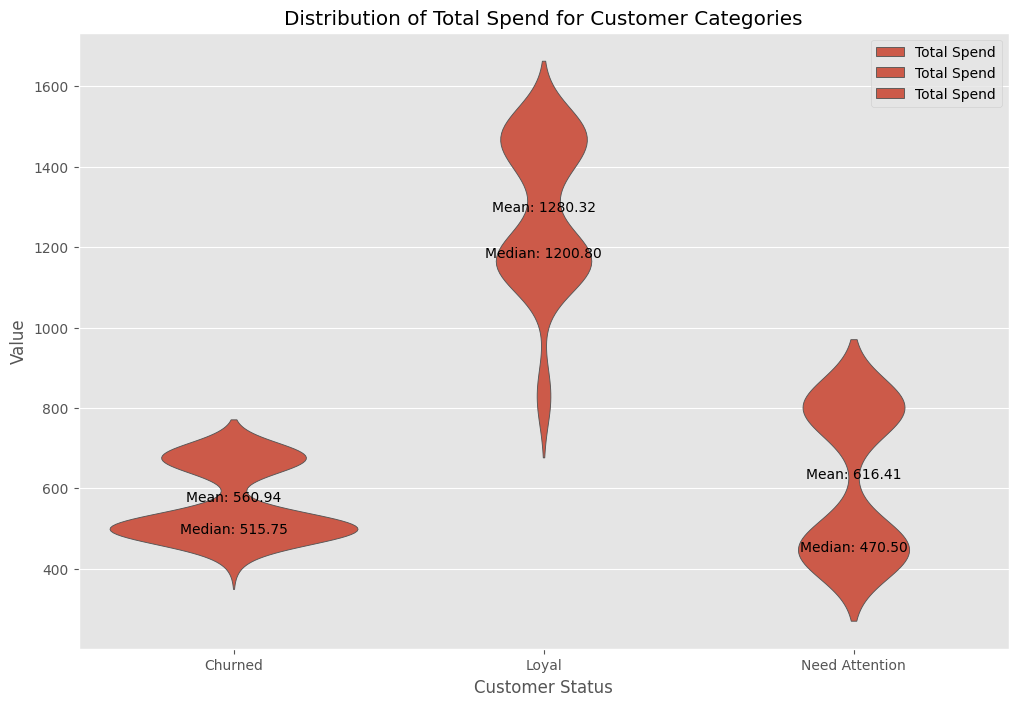

In [25]:
# Let's take a look at the distribution of the numerical variables for each of the customer segment

combined_customers = pd.concat([churned_customers.assign(Customer_Status='Churned'), 
                                loyal_customers.assign(Customer_Status='Loyal'),
                                need_attention.assign(Customer_Status='Need Attention')])

plt.figure(figsize = (12,8))
sns.violinplot(x = 'Customer_Status', y = 'Total Spend', data = combined_customers,  inner=None, label='Total Spend')

for i, category in enumerate(['Churned', 'Loyal', 'Need Attention']):
    
    mean_value = combined_customers.loc[combined_customers['Customer_Status'] == category, 'Total Spend'].mean()
    median_value = combined_customers.loc[combined_customers['Customer_Status'] == category, 'Total Spend'].median()
    
    plt.text(i, mean_value, f'Mean: {mean_value:.2f}', ha='center', va='bottom', color='black', fontsize=10)
    plt.text(i, median_value, f'Median: {median_value:.2f}', ha='center', va='top', color='black', fontsize=10)


plt.title('Distribution of Total Spend for Customer Categories')
plt.xlabel('Customer Status')
plt.ylabel('Value')
plt.legend()
plt.show()

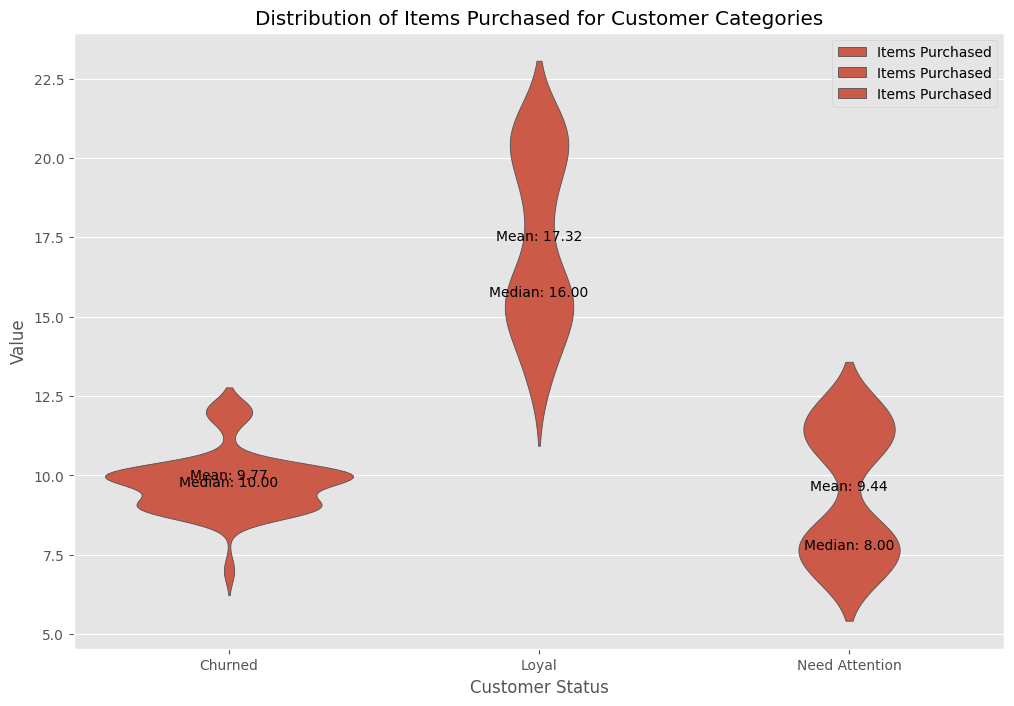

In [26]:
plt.figure(figsize = (12,8))
sns.violinplot(x = 'Customer_Status', y = 'Items Purchased', data = combined_customers,  inner=None, label='Items Purchased')

for i, category in enumerate(['Churned', 'Loyal', 'Need Attention']):
    
    mean_value = combined_customers.loc[combined_customers['Customer_Status'] == category, 'Items Purchased'].mean()
    median_value = combined_customers.loc[combined_customers['Customer_Status'] == category, 'Items Purchased'].median()
    
    plt.text(i, mean_value, f'Mean: {mean_value:.2f}', ha='center', va='bottom', color='black', fontsize=10)
    plt.text(i, median_value, f'Median: {median_value:.2f}', ha='center', va='top', color='black', fontsize=10)


plt.title('Distribution of Items Purchased for Customer Categories')
plt.xlabel('Customer Status')
plt.ylabel('Value')
plt.legend()
plt.show()

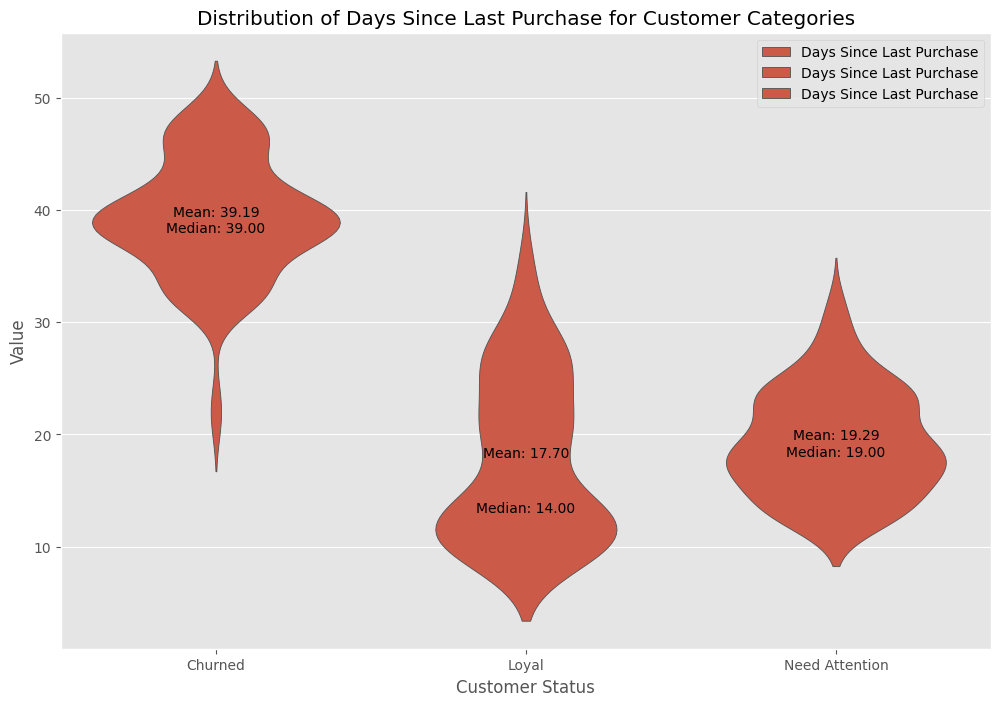

In [27]:
plt.figure(figsize = (12,8))
sns.violinplot(x = 'Customer_Status', y = 'Days Since Last Purchase', data = combined_customers,  inner=None, label='Days Since Last Purchase')

for i, category in enumerate(['Churned', 'Loyal', 'Need Attention']):
    
    mean_value = combined_customers.loc[combined_customers['Customer_Status'] == category, 'Days Since Last Purchase'].mean()
    median_value = combined_customers.loc[combined_customers['Customer_Status'] == category, 'Days Since Last Purchase'].median()
    
    plt.text(i, mean_value, f'Mean: {mean_value:.2f}', ha='center', va='bottom', color='black', fontsize=10)
    plt.text(i, median_value, f'Median: {median_value:.2f}', ha='center', va='top', color='black', fontsize=10)


plt.title('Distribution of Days Since Last Purchase for Customer Categories')
plt.xlabel('Customer Status')
plt.ylabel('Value')
plt.legend()
plt.show()

As visualised, Loyal Customers have purchased higher amounts of items on average than Churned Customers. They also purchased more recently than Churned Customers.

4. Is there a statistically significant difference between loyal customers and churned customers?
   
   This is the last step of rejecting the null hypothesis, and it will be done with a t-test to find the difference between Loyal and Churned Customers.

In [28]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(churned_customers['Total Spend'], loyal_customers['Total Spend'])
print("T-test Results for Total Spend (Churned vs. Loyal):")
print("T-statistic:", t_statistic)
print("P-value:", p_value)
if p_value < 0.05:
    print('Null hypothesis REJECTED.')
else:
    print('Null hypothesis ACCEPTED.')

t_statistic, p_value = ttest_ind(churned_customers['Items Purchased'], loyal_customers['Items Purchased'])
print("T-test Results for Items Purchased (Churned vs. Loyal):")
print("T-statistic:", t_statistic)
print("P-value:", p_value)
if p_value < 0.05:
    print('Null hypothesis REJECTED.')
else:
    print('Null hypothesis ACCEPTED.')

t_statistic, p_value = ttest_ind(churned_customers['Days Since Last Purchase'], loyal_customers['Days Since Last Purchase'])
print("T-test Results for Days Since Last Purchase (Churned vs. Loyal):")
print("T-statistic:", t_statistic)
print("P-value:", p_value)
if p_value < 0.05:
    print('Null hypothesis REJECTED.')
else:
    print('Null hypothesis ACCEPTED.')

T-test Results for Total Spend (Churned vs. Loyal):
T-statistic: -34.10085066797874
P-value: 6.658726010506675e-89
Null hypothesis REJECTED.
T-test Results for Items Purchased (Churned vs. Loyal):
T-statistic: -25.642091643994764
P-value: 1.8152903613761567e-67
Null hypothesis REJECTED.
T-test Results for Days Since Last Purchase (Churned vs. Loyal):
T-statistic: 23.94900626671384
P-value: 1.0152668506029543e-62
Null hypothesis REJECTED.


We have successfully found our loyal customers.

These customers are to be retained and given extra care.

Here we conclude our EDA.

Prediction Modeling:

In the 3rd and last phase of the project, a logistic regression prediction model for predicting the churn.

As evident from the EDA, the two main predictors of churn is

1. When a customer's average rating drops below 4
2. When a customer's satisfaction level becomes NOT satisfied

   
The logistic regression model is going to be based on these two predictors.

In [29]:
def determine_churn(row):
    if row['Average Rating'] < 4 and row['Satisfaction Level'] != 'Satisfied':
        return 1  # Churned
    else:
        return 0  # Not churned

In [31]:
df['Potential Churn'] = df.apply(determine_churn, axis=1)

X = df.drop(columns=['Customer ID', 'Potential Churn'])
y = df['Potential Churn']

In [32]:
from sklearn.preprocessing import OneHotEncoder

df['Churned'] = ((df['Average Rating'] < 4) & (df['Satisfaction Level'] != 'Satisfied')).astype(int)

# create features
X = df[['Average Rating']]
y = df['Churned']

# one hot encoding
encoder = OneHotEncoder(drop = 'first')
X_encoded = encoder.fit_transform(df[['Satisfaction Level']])
X_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_encoded,
                                                 columns = encoder.get_feature_names_out(['Satisfaction Level']))

In [33]:
X = pd.concat([X, X_encoded_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score', accuracy)
print(classification_report(y_test, y_pred))

Accuracy score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        26

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


For class 0 (non-churn), the model achieved perfect precision, recall, and F1-score, indicating that it correctly predicted all instances of non-churn.

For class 1 (churn), the model also achieved perfect precision, recall, and F1-score, indicating that it correctly predicted all instances of churn.